# Stroke Prediction
Author: Kim Hazed Delfino

# Imports

In [39]:
import pandas as pd
import numpy as np
#libs for visuals
import matplotlib.pyplot as plt
import seaborn as sns


## Load the Data

In [3]:
path = r"C:\Users\kdelfino\Documents\GitHub\ML_stroke_prediction\healthcare-dataset-stroke-data.csv"
df = pd.read_csv(path)

## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df["stroke"].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

 `Stroke Prediction`
- [Stroke_dataset]((https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/code))

- A Stroke is a health condition that causes damage by tearing the blood vessels in the brain. It can also occur when there is a halt in the blood flow and other nutrients to the brain. According to the World Health Organization (WHO), stroke is the leading cause of death and disability globally, This model will try to predict if a person will have stroke or not

- Each row represents a person's features

- This Model will solve a `Classification Problem`

- There area `11 Feature Matrices` in this dataset excluding `Target Vector`

- This dataset contains `5110 rows`

- I find this Dataset to be challenging because the ratio between target distribution is almost 9:1 in favor of 0's as opposed to 1's 

In [7]:
# Check for missing values
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- Looks like we have missing values in `bmi` feature, the amount of missing data is not high/low enough to justify dropping the column so we will have to handle them during pre-processing to avoid data leakage

In [8]:
# Drop id column for irrelevant data
df.drop(columns=['id','ever_married'],inplace=True)

- Dropped the `id` and `ever_married` columns since it's not providing any value to our prediction

In [9]:
#check for duplicate
df.duplicated().sum()

0

In [10]:
df.sample(5)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2126,Female,44.0,0,0,Private,Rural,222.29,38.2,never smoked,0
3204,Female,66.0,0,0,Private,Urban,80.10,32.0,never smoked,0
3613,Female,76.0,1,0,Self-employed,Urban,78.70,27.6,formerly smoked,0
1395,Female,55.0,0,0,Private,Urban,64.45,26.7,never smoked,0
533,Male,51.0,0,0,Private,Urban,98.41,32.1,never smoked,0


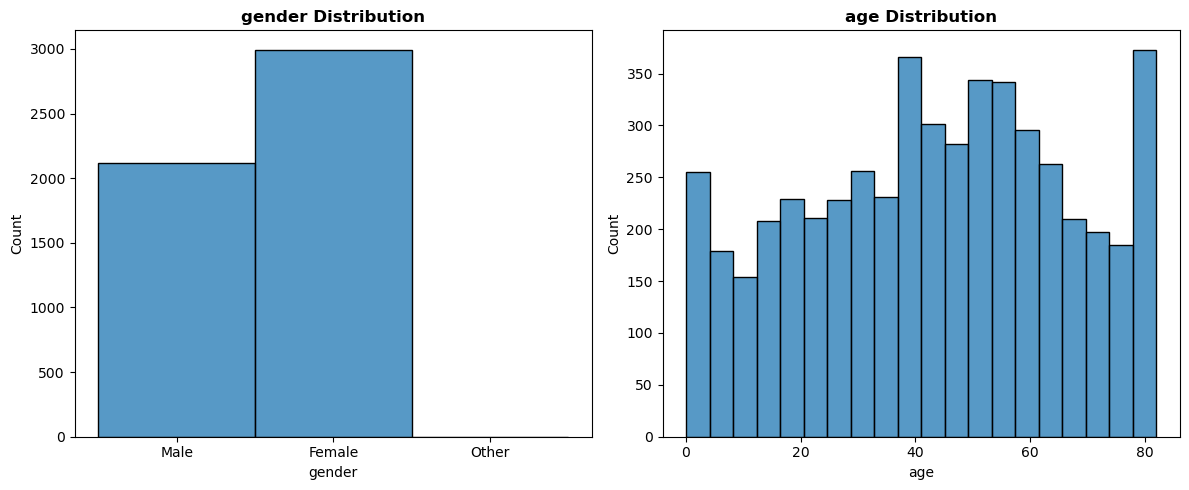

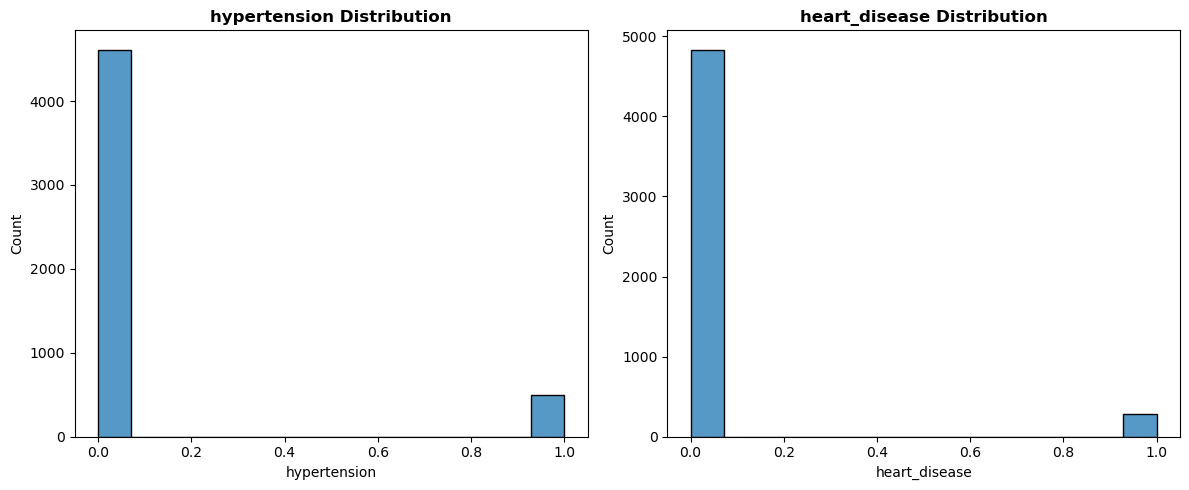

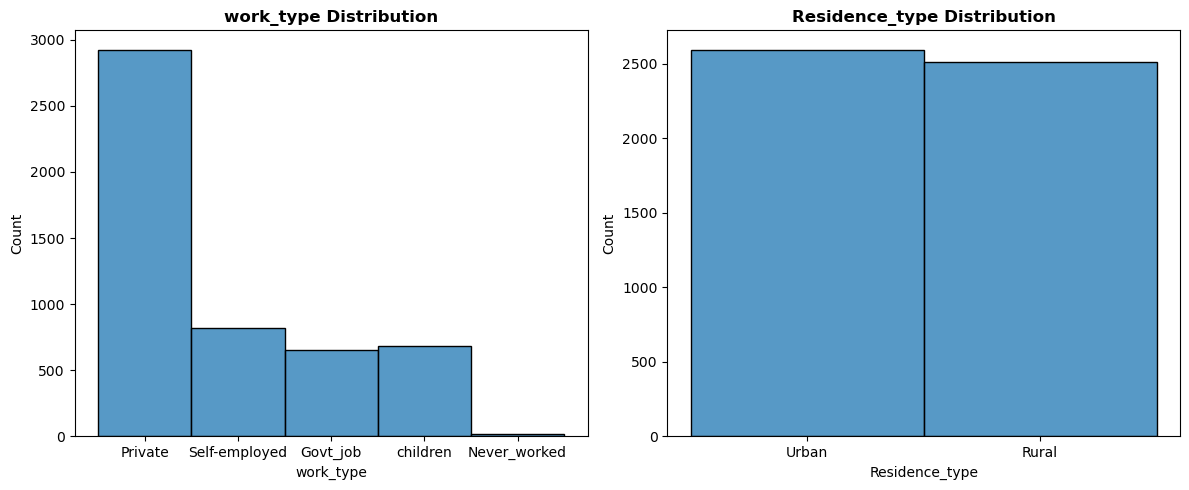

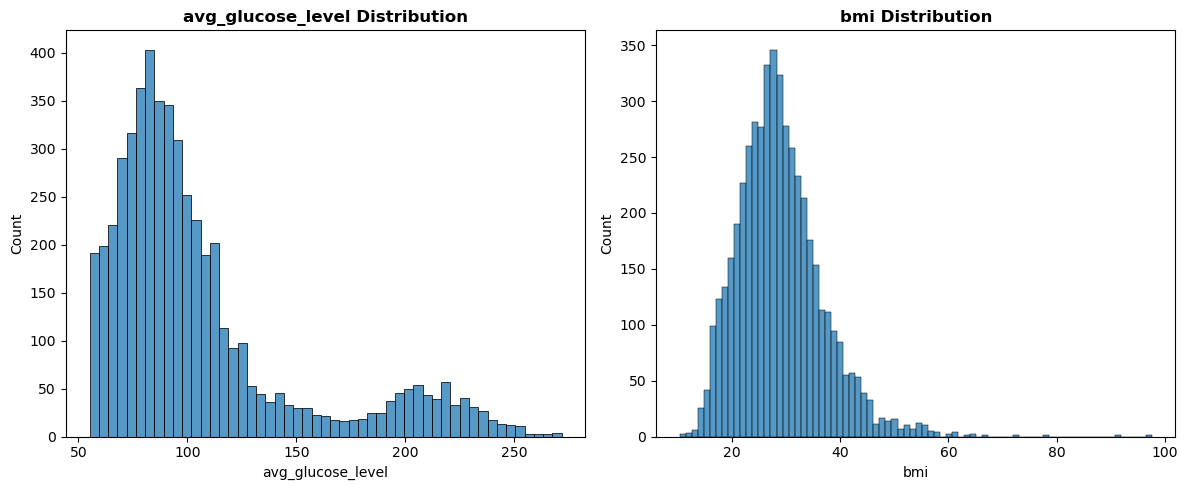

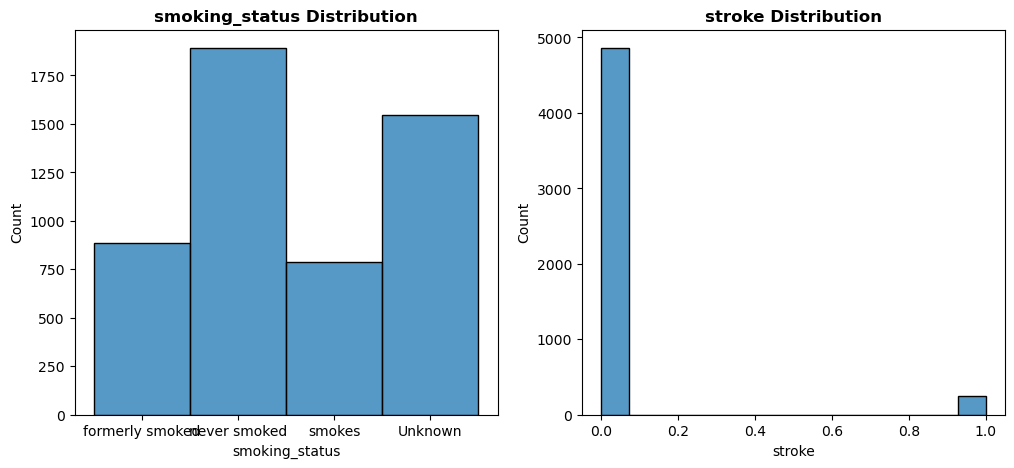

In [11]:
col_ax = 0
row_limit = 4
counter = 0
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
# Iterate to all features and display Historgram
for col in df.columns:
    # Set Historgram 
    ax=sns.histplot(data=df, x=col, ax=axes[col_ax])
    axes[col_ax].set_title(col+" Distribution", fontweight="bold")
    
    # Display every 2 cols and set new fig
    if col_ax == 1 and counter != row_limit:
        fig.tight_layout()
        fig, axes = plt.subplots(ncols=2, figsize=(12,5))
        col_ax = 0
        counter += 1
    else:
        col_ax += 1


- Here we can see the Distributions for all features and target
- `bmi` seemed to have impossible value but upon further research, there was a record in the past of bmi went as high as `105`
- `gender` have another data point called `other` that we need to look into
- `smoking_status` have a lot of `unknown` that we need to handle during preprocessing

### Check for Data Inconcistency

In [42]:
# Select all object colums
cat_cols = df.select_dtypes(include="object")

In [13]:
# Check for Naming Inconsistency
for col in cat_cols:
    print(f"Checking {col}:\n{df[col].value_counts()}")
    # Separtor for readability 
    print("___________________________")

Checking gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
___________________________
Checking work_type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
___________________________
Checking Residence_type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
___________________________
Checking smoking_status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
___________________________


In [74]:
chiledren_df = df[df["work_type"]== "children"]
chiledren_df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,687.000000,687.0,687.000000,687.000000,671.000000,687.000000
mean,6.841339,0.0,0.001456,94.400277,20.038003,0.002911
std,4.533364,0.0,0.038152,26.658955,4.540639,0.053916
min,0.080000,0.0,0.000000,55.340000,10.300000,0.000000
25%,2.000000,0.0,0.000000,76.255000,17.150000,0.000000
50%,6.000000,0.0,0.000000,90.220000,18.900000,0.000000
75%,11.000000,0.0,0.000000,108.710000,21.600000,0.000000
max,16.000000,0.0,1.000000,219.810000,41.700000,1.000000


In [14]:
# Create filter for other
df[df["gender"]=="Other"]

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,Private,Rural,143.33,22.4,formerly smoked,0


- `dropping` the gender `other` since it's insignificant value and outlier in our dataset

In [15]:
# Drop index where other is located
df.drop(index=3116,inplace=True)

In [16]:
# Double check
df[df["gender"]=="Other"]

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [66]:
# Display dataset again
df.sample(5)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2535,Male,23.0,0,0,Private,Rural,82.39,31.8,Unknown,0
1928,Female,5.0,0,0,children,Rural,102.04,18.5,Unknown,0
534,Female,20.0,0,0,Private,Urban,127.18,31.0,Unknown,0
3780,Male,49.0,0,0,Private,Urban,175.74,45.4,Unknown,0
1363,Female,62.0,0,0,Private,Rural,126.99,29.4,formerly smoked,0


### Multi Variate Exploratory Analysis

In [43]:
# Import warning to prevent warning messages
import warnings
warnings.filterwarnings("ignore")

In [48]:
# Set Correlation from the entire numerical datapoints
corr = df.corr()
mask = np.triu(np.ones_like(corr))

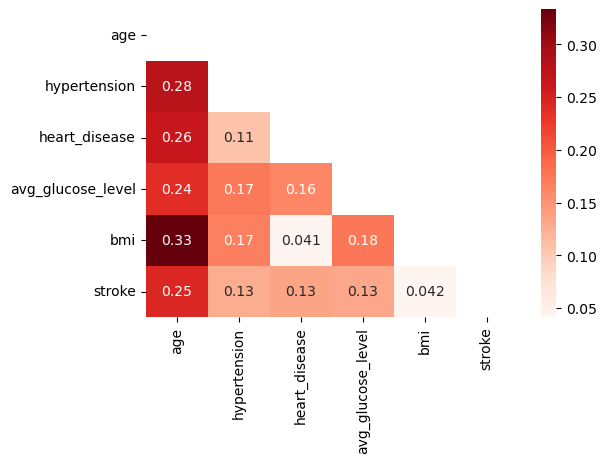

In [54]:
# Set Heatmap
fix, ax = plt.subplots(figsize= (6,4))
ax = sns.heatmap(corr, cmap='Reds', annot = True, mask= mask );

- Here we can see that we **`Do not`** have **`Moderate or Strong`** correlation between features but `Age` does show some correlation with the rest of numerical features with `bmi` being the highest

In [36]:
# Create age filter starting at the first stroke was recorded
age_filtered = df[df["age"] > 13]

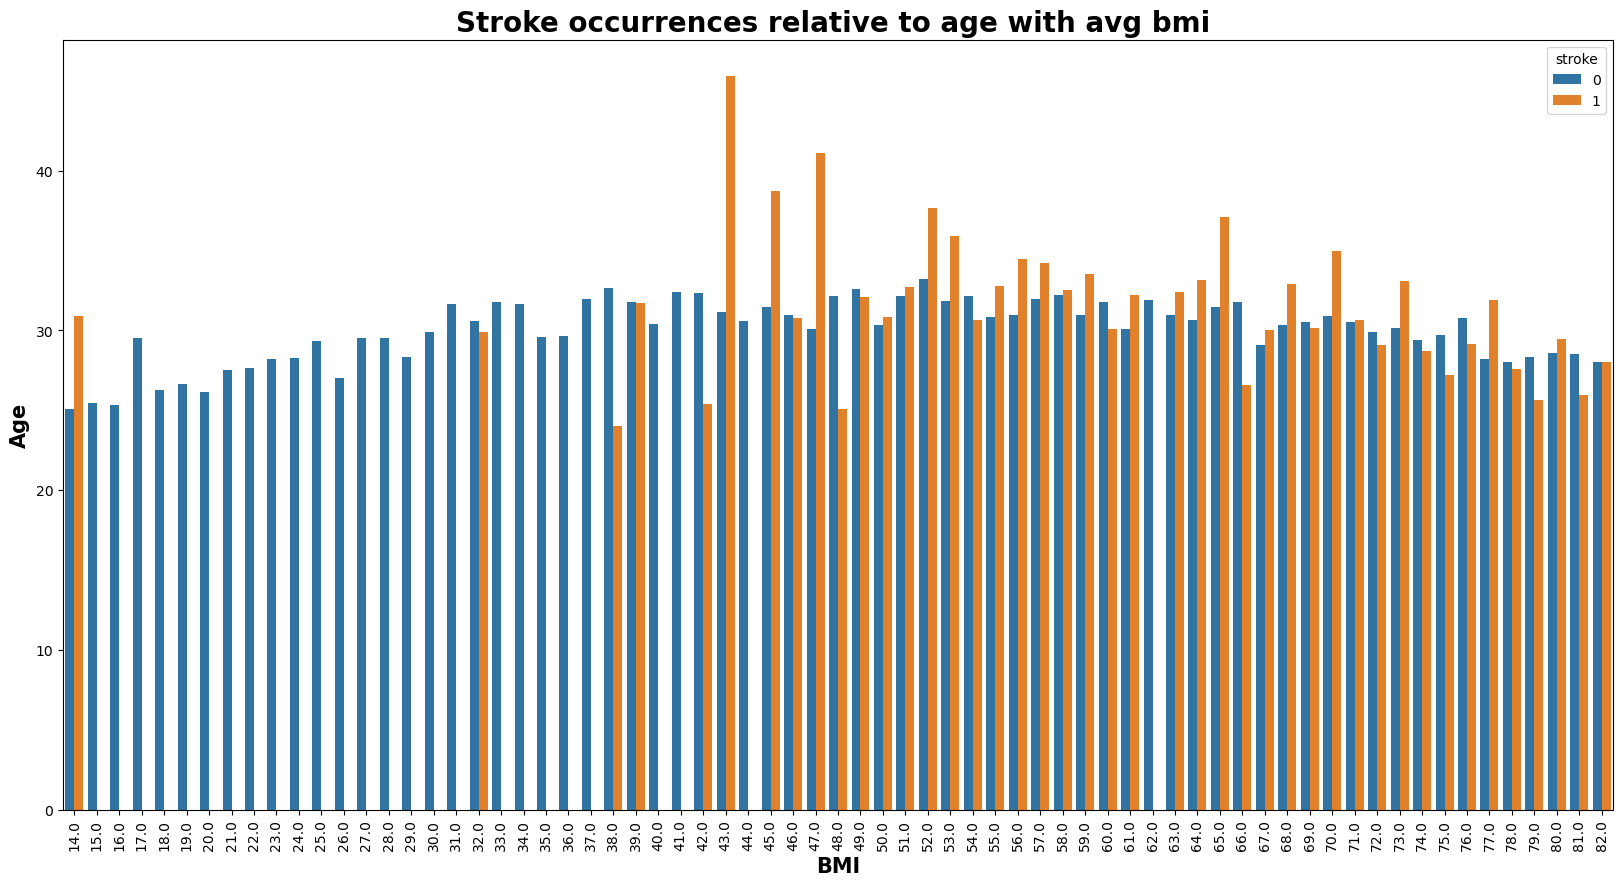

In [65]:
# Set bar plot 
fig, ax = plt.subplots(figsize = (20, 10))
ax = sns.barplot(x= "age", y="bmi", data=age_filtered,
                  hue="stroke", errorbar=None)
ax.set_title("Stroke occurrences relative to age with avg bmi ",
             fontsize= 20, fontweight= "bold")
ax.set_ylabel("Age", fontsize=15, fontweight="bold")
ax.set_xlabel("BMI", fontsize=15, fontweight="bold")
plt.xticks(rotation=90);

- Here we can see that the earliest age of stroke in our dataset was `14` and the next occurrence was age 32 but the trend started to become more obvious and `more frequent from the age of 32 and as you get older`